# Notebook pour l'implémentation de Tesseract OCR sur des plaques d'immatriculation française

- Tesseract OCR lien : https://github.com/tesseract-ocr/tesseract
- Python Tesseract Wrapper : https://github.com/madmaze/pytesseract

Note : Pytesseract dépend de Pillow qui fonctionne en RGB donc après l'extraction, pas besoin de reconvertir l'image en RGB

Prérequis:
- Installer Tesseract OCR via les executables de [UB Manheim](https://github.com/UB-Mannheim/tesseract/wiki)
- Installer le wrapper Pytesseract pour utiliser les fonctions en Python (ok with conda install)

Pour commencer : [PyImageSearch](https://www.pyimagesearch.com/2020/05/25/tesseract-ocr-text-localization-and-detection/)

https://www.youtube.com/watch?v=AAPZLK41rek

In [10]:
import pytesseract as pyt
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from time import time
import numpy as np
import pylab as pl

In [2]:
path = os.getcwd()
print(path)

C:\Users\VArri\Documents\GitHub\OCR


In [3]:
T = np.zeros(9)
val = time()

In [4]:
val = time()
# im = Image.open("licenseplatefr.jpg")
# im = cv2.imread("licenseplate2.jpg")
im = cv2.imread("lr4.jpg")
T[0]=time()-val
val=time()
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
T[1]=time()-val

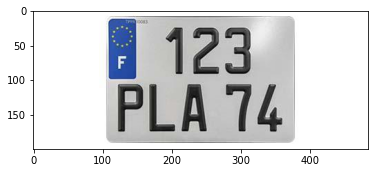

In [5]:
plt.imshow(im)
plt.show()

***
Prétraitements conformément à la vidéo Youtube

- `cv2.resize()`: Une recherche rapide sur le net donne une résolution minimale de 300dpi pour que Tesseract fonctionne de manière optimale sur des images hautes résolutions. Un autre article sur [StackOverflow](https://stackoverflow.com/questions/50503960/how-to-increase-dpi-with-opencv) recommande une taille de 30 pixels pour la largeur de chaque lettre/chiffre à détecter. Le dpi ne serait qu'une valeur dans le header du fichier JPEG ou PNG utilisé uniquement au moment de printer l'image donc il est plus intéressant de modifier la taille de l'image pour avoir des lettres/chiffres avec le bon nombre de pixels. 

- `cv2.GaussianBlur`: Applique un flou pour faciliter le seuillage Otsu qui suit. Cela permet d'avoir un seuillage plus robuste au bruit, en quelque sorte cela rend l'histogramme de luminosité des pixels moins bruité. 

- `cv.THRESH_OTSU` : décide automatiquement de quelle valeur choisir pour le meilleur seuillage en utilisant l'histogramme d'intensité lumineuse des pixels de l'image. Techniquement, il trouve la valeur entre les deux pics principaux de l'histogramme qui minimise la variance dans chacune des classes. La fonction `cv2.threshold` retourne la valeur du seuil optimal ainsi que l'image seuillée.

- `cv2.dilate ` : dégrade l'image volontairement, utilise un élément spécifique structurant pour effectuer une telle tâche. On crée donc un noyau rectangulaire qui va nous servir à effectuer la dilatation pour rendre le seuillage plus clair. 

- `cv2.findContours` trouve beaucoup de contours qui fittent bien les lettres/chiffres mais on préfère pour l'utilisation de Pytesseract des contours en boite plus régulier. On réutilise donc la fonction `cv2.boundingRect` pour transformer chaque contour en rectangle ce qui est bien plus adapté pour utiliser Pytesseract. 

- `sort` permet de classer les élements de la liste contours sur l'élément key. En l'occurence, key est une fonction qui renvoie l'abscisse du contour. Les contours sont donc classés de la gauche vers la droite. 



In [6]:
val=time()
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
T[2]=time()-val

# gray = cv2.resize(gray, ()) # pas obligé selon la taille du crop
val=time()
gray = cv2.GaussianBlur(gray, (3,3), 0) 
T[3]=time()-val

val=time()
_, im_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)
T[4]=time()-val

val=time()
ker = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
dilated = cv2.dilate(im_thresh, ker, iterations=1)
T[5]=time()-val

val=time()
contours, hierarchy = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
T[6]=time()-val

sort = sorted(contours, key=lambda ctr: (cv2.boundingRect(ctr)[1], cv2.boundingRect(ctr)[0])) 
plaq = []

for ctr in sort:
    
    x,y,w,h = cv2.boundingRect(ctr)
    im_shape = gray.shape
    if w<20: continue 
    
    if not 1.5 < h/w < 5.0 : continue 
    
    if not 0.25 < h/im_shape[0] < 0.38: continue 
    # print(h/im_shape[0])
    # print((x,y,w,h))
    # print(im_shape)
    
    # cv2.drawContours(gray, contours[contours.index(ctr)], -1, (0,0,0), 5) # draw too much complicated contours 
    cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,0), 5)
    #plt.imshow(gray)
    #plt.colorbar()
    #plt.show()
    
    val=time()
    crop = im_thresh[y-3:y+h+3, x-3:x+w+3]
    blur = cv2.medianBlur(crop, 5)
    T[7]+=time()-val
    
    val=time()
    plaq.append(pyt.image_to_string(crop, config='-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 8 --oem 3'))
    T[8]+=time()-val

In [7]:
T

array([2.99143791e-03, 9.98020172e-04, 0.00000000e+00, 4.96292114e-03,
       0.00000000e+00, 0.00000000e+00, 9.97543335e-04, 2.96592712e-03,
       2.50761843e+00])